In [150]:
from p4utils.utils.helper import load_topo
from p4utils.utils.sswitch_thrift_API import SimpleSwitchThriftAPI
import argparse
import shutil
import os
import json
from pprint import pprint
from collections import defaultdict, Counter

from matplotlib import pyplot as plt
import numpy as np

import struct
import crcmod

import matplotlib as mpl
mpl.rcParams.update({
    'axes.spines.right': False,
    'axes.spines.top': False,
})
plt.rc('figure', figsize=[6,3.5])
plt.rc('font', family='Times New Roman', size=18)

In [37]:
topo = load_topo("topo/fat-tree-k4.json")

m_IS = 7
m_NS = 10

In [43]:
def static(topo):
    all_paths = []
    flow_set = set()
    for src_h in topo.get_hosts():
        for dst_h in topo.get_hosts():
            if src_h == dst_h: continue
            if (src_h, dst_h) in flow_set or (dst_h, src_h) in flow_set: continue
            flow_set.add((src_h, dst_h))
            all_paths += topo.get_shortest_paths_between_nodes(src_h, dst_h)
    all_paths = set([p[1:-1] for p in all_paths])
    path_lens = Counter([len(p) for p in all_paths])
    return path_lens

In [134]:
topo_list = [
    "k2",
    "k4",
    "s2l4",
    "s2l8",
    "s4l8",
    # "s4l16",
    "s6l8",
    # "s8l8",
    # "s8l16",
    "r-n16d6",
    "r-n18d8",
    "r-n20d10",
]

In [135]:
def cal_NS(name):
    with open("topo/paths-{}.json".format(name), "r") as f:
        path_ctrl = json.load(f)
    control_count = 0
    for ctrl in path_ctrl.values():
        for c in ctrl['controls']:
            if c != 0:
                control_count += 1
    return control_count

In [136]:
entry_IS_list, entry_NS_list = [], []
path_list = []
link_list = []
switch_list = []
for name in topo_list:
    topo_path = "topo/topo-{}.json".format(name)
    topo = load_topo(topo_path)
    path_lens = static(topo)
    
    entry_num = 0
    for hop_num, path_num in path_lens.items():
        entry_num += hop_num * path_num
    print(name, sum(path_lens.values()), entry_num)
    
    with open(topo_path, "r") as f:
        topo_json = json.load(f)
    link_list.append(len(topo_json['links']))
    switch_list.append(len(topo.get_switches()))
    
    path_list.append(sum(path_lens.values()))
    entry_IS_list.append(entry_num)
    entry_NS_list.append(cal_NS(name))

k2 1 5
k4 112 512
s2l4 16 40
s2l8 64 176
s4l8 120 344
s6l8 176 512
r-n16d6 234 654
r-n18d8 369 1035
r-n20d10 586 1658


In [196]:
entry_NS_list

[0, 48, 0, 0, 56, 220, 82, 216, 587]

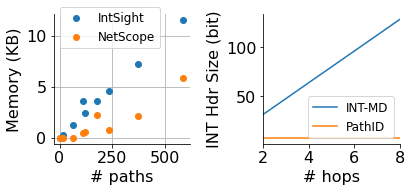

In [193]:
plt.rc('font', family='Times New Roman', size=16)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
kwargs = dict(zorder=100)
axes[0].scatter(path_list, np.array(entry_IS_list) * m_IS / 1e3, label='IntSight', **kwargs)
axes[0].scatter(path_list, np.array(entry_NS_list) * m_NS / 1e3, label='NetScope', **kwargs)
axes[0].set_xticks([0, 250, 500])
axes[0].set_ylabel("Memory (KB)")
axes[0].set_xlabel("# paths")
axes[0].legend(loc="upper left", bbox_to_anchor=(0, 1.1), prop=dict(size=12)).set_zorder(10)
axes[0].grid()

axes[1].set_ylabel("INT Hdr Size (bit)")
axes[1].set_xlabel("# hops")

hops = np.linspace(1, 8, 2)
axes[1].plot(hops, 16 * hops, label="INT-MD")
axes[1].plot(hops, np.ones_like(hops) * 8, label="PathID")
axes[1].set_xlim((2, 8))
axes[1].set_xticks([2, 4, 6, 8])
axes[1].legend(prop=dict(size=12))

plt.tight_layout()

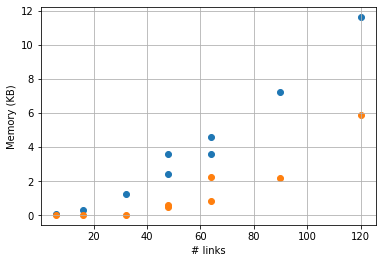

In [137]:
plt.scatter(link_list, np.array(entry_IS_list) * m_IS / 1e3, label='IntSight')
plt.scatter(link_list, np.array(entry_NS_list) * m_NS / 1e3, label='NetScope')
plt.ylabel("Memory (KB)")
plt.xlabel("# links")
plt.grid()

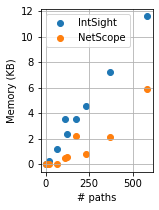

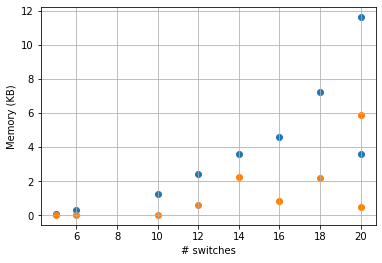

In [139]:
plt.scatter(switch_list, np.array(entry_IS_list) * m_IS / 1e3, label='IntSight')
plt.scatter(switch_list, np.array(entry_NS_list) * m_NS / 1e3, label='NetScope')
plt.ylabel("Memory (KB)")
plt.xlabel("# switches")
plt.grid()